# Read Me

- Pada kasus kali ini, saya mengerjakan kasus mengenai analisis sentiment analisis dari data tweet yang didapatkan dari twitter.
***
- Saya hanya menggunakan 3 model menggunakan Logistic Regression, Naive Bayes, dan LinearSVC karena algoritma lain seperti KNN, Dtree, Random Forest, SVM sangat lama untuk dirun.
***

## 0.Load Library 
- Memuat seluruh library yang akan digunakan

In [1]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
from nltk.corpus import stopwords
import nltk 

#import re, unicode
import re, unicodedata

#import sklearn preprocessing 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import sklearn for model evaluation 
from sklearn.metrics import roc_auc_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import beaurtiful soup 
from bs4 import BeautifulSoup

#textblob
from textblob import Word
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

## 1. Load Datasets
- Loading data yang akan digunakan.

In [2]:
df = pd.read_csv('clean_tweet.csv')

In [3]:
#Melihat 5 data teratas
df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


## 2. Informasi Data Secara Umum

In [4]:
#Melihat informasi data secara umum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [5]:
#Melihat nama kolom dari data
df.columns

Index(['text', 'target'], dtype='object')

In [6]:
#Melihat dimensi dari data
#Terdapat 1.600.000 data dengan 2 features
df.shape

(1600000, 2)

In [7]:
#Melihat statistika deskriptif dari tipe data string
df.describe(include='object')

,text
count,1596753
unique,1524088
top,thanks
freq,1876


In [8]:
#melihat statistika deskriptis dari data numerikal
df.describe()

,target
count,1600000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


## 3. Handling Missing Values

In [9]:
#Melihat jumlah data yang missing
df.isnull().sum()

text      3247
target       0
dtype: int64

In [10]:
#Data yang hilang sebesar 0.2%
percentage = (df.isnull().sum() / len(df)) * 100
percentage

text      0.202937
target    0.000000
dtype: float64

In [11]:
#Drop data yang null
df.dropna(inplace=True)

In [12]:
#Crosscheck
df.isnull().sum()

text      0
target    0
dtype: int64

## 4. Data Preprocessing

### 4.1 Menghapus Punctuation
- Punctuation itu seperti tanda seru, tanda tanya, titik, koma.
- Biar text hanya terdiri dari huruf dan angka.

In [13]:
df['text'] = df['text'].str.replace('[^\w\s]','')
df.head(10)

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0
5,not the whole crew,0
6,need a hug,0
7,hey long time no see yes rains a bit only a bi...,0
8,k nope they didn t have it,0
9,que me muera,0


### 4.2 Menghapus Stopwords
- Stopwords itu kata umum yang sering muncul dan tidak memberikan makna seperti I, you dll.

In [14]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head(10)

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rains bit bit lol fine t...
8                                               k nope
9                                            que muera
Name: text, dtype: object

### 4.3 Menghapus Kata Tidak Penting dan Kata Sering Muncul

In [15]:
#Menghitung jumlah kata yang muncul
common = pd.Series(' '.join(df['text']).split()).value_counts()
common[:10]

good     91355
day      89776
get      82176
like     78582
go       74031
today    68226
work     64960
love     64857
going    64633
got      61454
dtype: int64

In [16]:
#Beberapa common words yang akan saya hapus adalah
#Saya akan menghapus kata yang panjangnya kurang dari 2 karena itu tidak memberikan informasi apa apa.
tidak_penting = []
for word in common.index:
    if len(word)<2:
        tidak_penting.append(word)
tidak_penting

['u',
 'x',
 'n',
 'b',
 'w',
 'r',
 'p',
 'c',
 'e',
 'g',
 'l',
 'k',
 'f',
 'v',
 'h',
 'j',
 'z',
 'q']

In [17]:
#Memasukan ke dalam fungsi
tidak_penting = list(tidak_penting)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in tidak_penting))
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [18]:
#Lalu ada juga beberapa kata yang sering muncul yang akan saya hapus
sering = ['one', 'time']
sering = list(sering)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sering))
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

### 4.4 Menghapus Kata yang Jarang Muncul

In [19]:
#Menghitung kata yang jarang muncul yang kemunculanya kurang dari 1
jarang = common[common<2][:1000]
jarang[:10]

funkadelic            1
naceous               1
hwkr                  1
benieuwd              1
lnou                  1
umqemcwqyi            1
shareaholic           1
mannnnnnnnnnnnnnnn    1
imakill               1
tahir                 1
dtype: int64

In [20]:
#Memasukan ke dalam fungsi
jarang = list(jarang.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in jarang))
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

### 4.5 Lemmatization
- Mengubah sebuah kata menjadi kata dasarnya.

In [21]:
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                                     behaving mad see
Name: text, dtype: object

## 5. Extract Feature
- Melakukan feature extraction untuk mendapatkan fitur fitur yang terpendam dan bisa memberikan informasi lebih.

### 5.1 Jumlah Kata
- Fitur ini menjelaskan jumlah kata dalam 1 tweet.

In [22]:
df['jumlah_kata'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df.head()

,text,target,jumlah_kata
0,awww bummer shoulda got david carr third day,0,8
1,upset update facebook texting might cry result...,0,11
2,dived many time ball managed save rest go bound,0,9
3,whole body feel itchy like fire,0,6
4,behaving mad see,0,3


### 5.2 Jumlah Characters
- Fitur ini menjelaskan jumlah huruf atau characters dalam 1 tweet

In [23]:
df['jumlah_char'] = df['text'].str.len()
df.head()

,text,target,jumlah_kata,jumlah_char
0,awww bummer shoulda got david carr third day,0,8,44
1,upset update facebook texting might cry result...,0,11,69
2,dived many time ball managed save rest go bound,0,9,47
3,whole body feel itchy like fire,0,6,31
4,behaving mad see,0,3,16


### 5.3 Rata Rata Panjang Kata
- - Fitur ini menjelaskan jumlah huruf dibagi dengan jumlah kata dalam 1 tweet.

In [24]:
df['rata_rata_kata'] = df['jumlah_char'] / df['jumlah_kata']
df['rata_rata_kata'] = [round(x, 2) for x in df['rata_rata_kata'].values]
df.head()

,text,target,jumlah_kata,jumlah_char,rata_rata_kata
0,awww bummer shoulda got david carr third day,0,8,44,5.50
1,upset update facebook texting might cry result...,0,11,69,6.27
2,dived many time ball managed save rest go bound,0,9,47,5.22
3,whole body feel itchy like fire,0,6,31,5.17
4,behaving mad see,0,3,16,5.33


### 5.4 Jumlah Character Numerik
- - Fitur ini menjelaskan jumlah huruf numerik dalam 1 tweet

In [25]:
df['numerik'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df.head()

,text,target,jumlah_kata,jumlah_char,rata_rata_kata,numerik
0,awww bummer shoulda got david carr third day,0,8,44,5.50,0
1,upset update facebook texting might cry result...,0,11,69,6.27,0
2,dived many time ball managed save rest go bound,0,9,47,5.22,0
3,whole body feel itchy like fire,0,6,31,5.17,0
4,behaving mad see,0,3,16,5.33,0


### 5.5 Labelling
- Memberikan label kepada target sehingga mudah dibaca.

In [26]:
#Membuat dictionary label
label = {
    0 : 'Negatif',
    1 : 'Positif'
}

In [27]:
#Membuat labelling
df['sentiment'] = df['target']
df['sentiment'].replace(label, inplace=True)

In [28]:
#Arranging kolom agar lebih mudah dibaca.
kolom = ['text', 'jumlah_kata', 'jumlah_char', 'rata_rata_kata', 'numerik', 'target', 'sentiment']
df = df[kolom]

## 6. Visualisasi Data
- Melakukan visualisasi agar bisa lebih mendalami characteristics dari data sehingga bisa menemukan insights dari data.

In [29]:
df.head()

,text,jumlah_kata,jumlah_char,rata_rata_kata,numerik,target,sentiment
0,awww bummer shoulda got david carr third day,8,44,5.50,0,0,Negatif
1,upset update facebook texting might cry result...,11,69,6.27,0,0,Negatif
2,dived many time ball managed save rest go bound,9,47,5.22,0,0,Negatif
3,whole body feel itchy like fire,6,31,5.17,0,0,Negatif
4,behaving mad see,3,16,5.33,0,0,Negatif


### 6.1 Korelasi Score
- Mencari correlation score untuk melihat hubungan linear antar features.

In [30]:
df.corr().style.background_gradient().set_precision(2)

,jumlah_kata,jumlah_char,rata_rata_kata,numerik,target
jumlah_kata,1,0.97,0.064,nan,-0.042
jumlah_char,0.97,1,0.26,nan,-0.029
rata_rata_kata,0.064,0.26,1,nan,0.042
numerik,nan,nan,nan,nan,nan
target,-0.042,-0.029,0.042,nan,1


- Saya hanya melihat korelasi antara features target dengan features yang lainya.
- Ternyata hampir semua features tidak berkorelasi dengan target.

### 6.2 Univariate Analysis
- Analisis per features

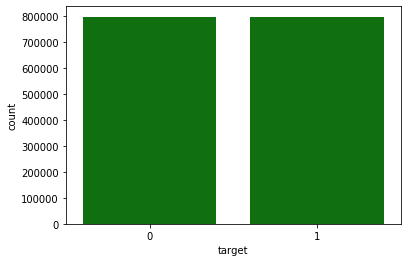

In [31]:
#Univariate Analysis Target
sns.countplot(df['target'], color='green')

- Jumlah nilai target 0 dan 1 ternyata hampir sama sehingga data sudah balance dan tidak perlu dilakukan treatment lain.

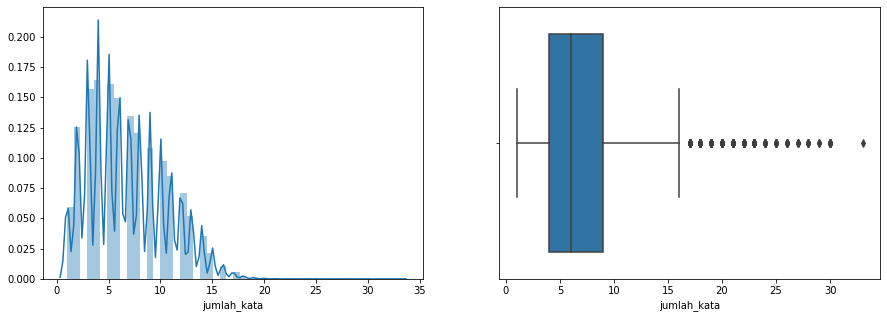

In [32]:
#Univariate Analysis Jumlah Kata
f = plt.figure(figsize=(15,5))

f.add_subplot(1,2,1)
sns.distplot(df['jumlah_kata'])

f.add_subplot(1,2,2)
sns.boxplot(df['jumlah_kata'])

- Dari distplot dapat dilihat bahwa jumlah kata tweet seseorang berada pada kisaran 5-10 kata.
- Dari boxplot dapat dilihat bahwa ada beberapa outliers yang jumlah katanya diatas 20.

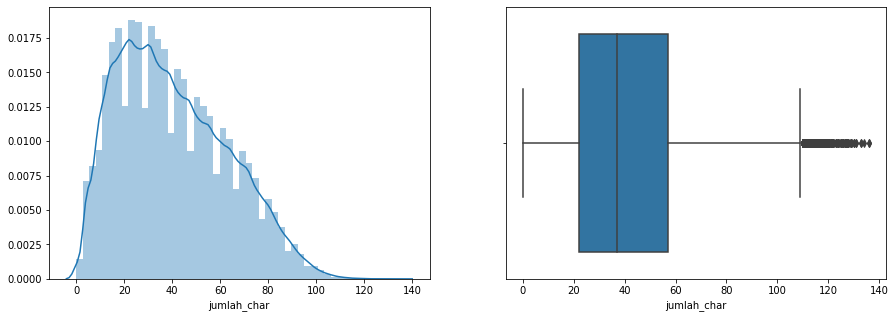

In [33]:
#Univariate Analysis Jumlah Char
f = plt.figure(figsize=(15,5))

f.add_subplot(1,2,1)
sns.distplot(df['jumlah_char'])

f.add_subplot(1,2,2)
sns.boxplot(df['jumlah_char'])

- Dari distplot, dapat dilihat bahwa sebagian besar jumlah huruf terpusat di angka 20-50 kata per tweet.
- Untuk boxplot dapat dilihat bahwa terdapat outliers yang jumlah katanya diatas 110.

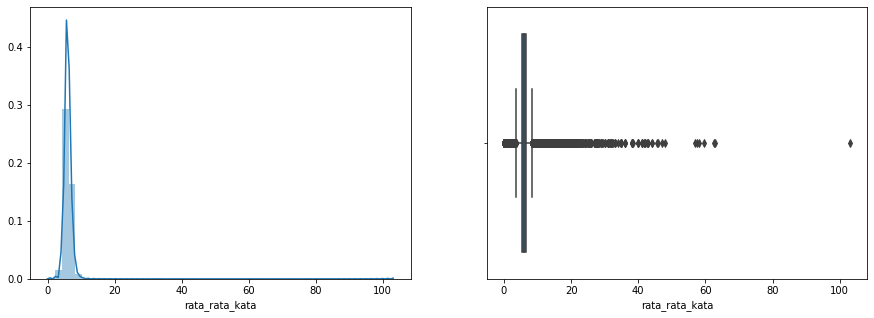

In [34]:
#Univariate Analysis Rata-Rata Kata
f = plt.figure(figsize=(15,5))

f.add_subplot(1,2,1)
sns.distplot(df['rata_rata_kata'])

f.add_subplot(1,2,2)
sns.boxplot(df['rata_rata_kata'])

- Rata-Rata kata terpusat di angka kurang dari 10.
- Terdapat banyak sekali outliers.

### 6.3 Perbandingan Antara Sentiment Negatif dan Positif

In [35]:
#Kategorikan text ke dalam positif dan negatif
positif = df.loc[df['sentiment'] == "Positif"]
negatif = df.loc[df['sentiment'] == "Negatif"]

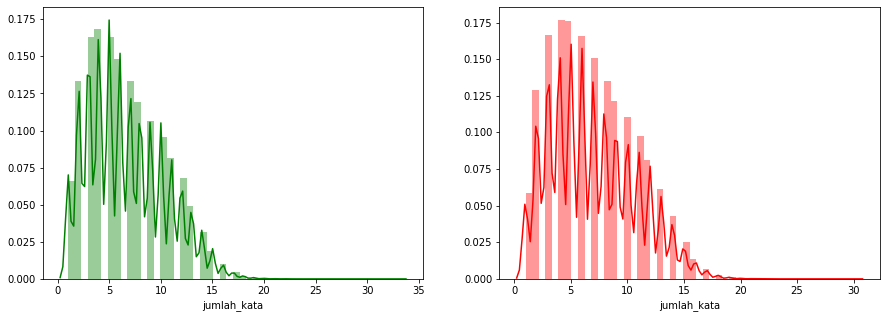

In [36]:
#Analysis Jumlah Kata
f = plt.figure(figsize=(15,5))

f.add_subplot(1,2,1)
sns.distplot(positif['jumlah_kata'], color='green')

f.add_subplot(1,2,2)
sns.distplot(negatif['jumlah_kata'], color='red')

plt.show()

- Warna hijau menandakan sentiment positif dan merah untuk sentiment negatif.
- Dapat dilihat ternyata distribusi dari jumlah_kata kedua sentiment hampir sama.

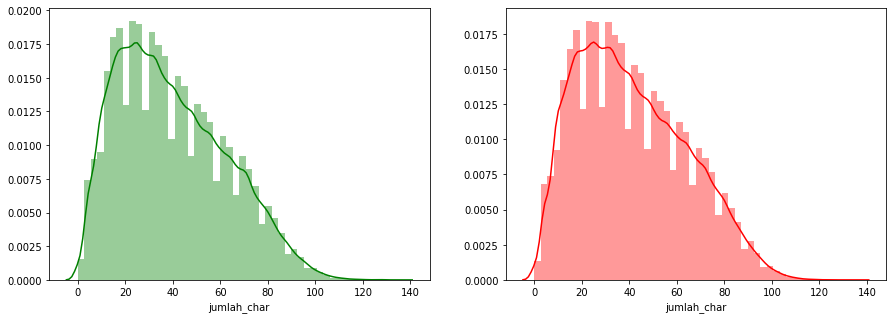

In [37]:
#Analysis Jumlah Huruf
f = plt.figure(figsize=(15,5))

f.add_subplot(1,2,1)
sns.distplot(positif['jumlah_char'], color='green')

f.add_subplot(1,2,2)
sns.distplot(negatif['jumlah_char'], color='red')

plt.show()

- Warna hijau menandakan sentiment positif dan merah untuk sentiment negatif.
- Dapat dilihat ternyata distribusi dari jumlah_char kedua sentiment hampir sama.

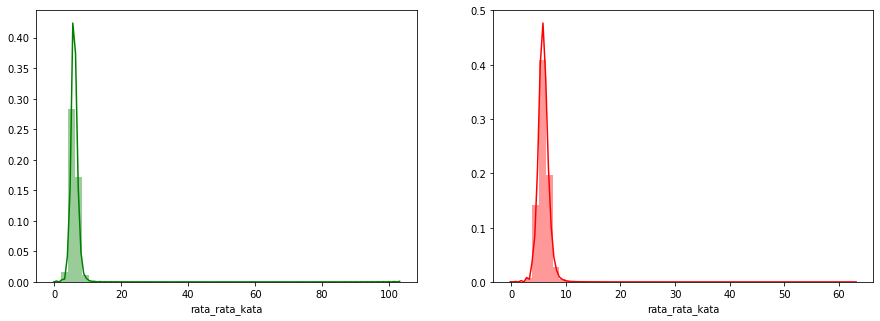

In [38]:
#Analysis Jumlah Huruf
f = plt.figure(figsize=(15,5))

f.add_subplot(1,2,1)
sns.distplot(positif['rata_rata_kata'], color='green')

f.add_subplot(1,2,2)
sns.distplot(negatif['rata_rata_kata'], color='red')

plt.show()

- Warna hijau menandakan sentiment positif dan merah untuk sentiment negatif.
- Dapat dilihat ternyata distribusi dari jumlah_char kedua sentiment hampir sama namun untuk rata_rata_kata dari sentiment positif memiliki outliers yang nilainya sampai 100.
- Sedangkan untuk rata_rata_kata untuk sentiment negatif nilai outliersnya hanya sampai 60.

### 6.3 Wordcloud

- Fungsi dari wordcloud adalah untuk menunjukan kata yang sering muncul dalam text.

In [39]:
#Wordcloud untuk sentiment positif
#Kategorikan text ke dalam positif dan negatif
positif = df.loc[df['sentiment'] == "Positif"]
negatif = df.loc[df['sentiment'] == "Negatif"]

In [40]:
#Gabungkan semua text ke dalam 1 paragraf
all_positif = "".join(positif['text'].values)
all_negatif = "".join(negatif['text'].values)

In [41]:
#Membuat fungsi wordcloud
def word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

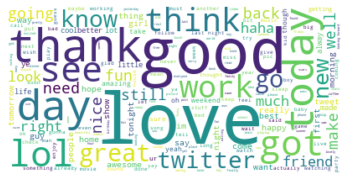

In [42]:
#Wordcloud untuk sentiment positif
word_cloud(all_positif)

- Dari wordcloud positif dapat dilihat kata yang sering muncul adalah love, thank, good.

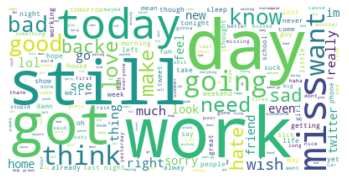

In [43]:
#Wordcloud untuk sentiment negatif
word_cloud(all_negatif)

- Dari wordcloud negatif beberapa kata yang sering muncul adalah work , still, miss.

## 7. Modelling

### 7.1 Feature Extraction Text
- Disini saya menggunakan CountVectorizer dan TF-IDF

In [44]:
df.head()

,text,jumlah_kata,jumlah_char,rata_rata_kata,numerik,target,sentiment
0,awww bummer shoulda got david carr third day,8,44,5.50,0,0,Negatif
1,upset update facebook texting might cry result...,11,69,6.27,0,0,Negatif
2,dived many time ball managed save rest go bound,9,47,5.22,0,0,Negatif
3,whole body feel itchy like fire,6,31,5.17,0,0,Negatif
4,behaving mad see,3,16,5.33,0,0,Negatif


In [45]:
#Membuat object CountVec
count_vectorizer = CountVectorizer(stop_words='english')

#Membuat object TF-IDF
tfidf = TfidfVectorizer(stop_words='english' )

### 7.2 Split Data Menjadi Training dan Testing

In [46]:
#Membuat variabel x dan y
x = df['text']
y = df['target']

In [47]:
#countvectorizer
x_vectorizer = count_vectorizer.fit_transform(x)

#tfidf vectorizer
x_tfidf = tfidf.fit_transform(x)

In [48]:
#train test split using countvectorizer 
train_x_vectorizer, test_x_vectorizer, train_y, test_y = train_test_split(x_vectorizer, y, test_size=0.2, random_state=4)

#train test split using tfidfvectorizer 
train_x_tfidf, test_x_tfidf, train_y, test_y = train_test_split(x_tfidf, y, test_size=0.2, random_state=4)

### 7.3 Machine Learning Menggunakan Logistic Regression
- Mengkombinasikan CountVectorizer dan LogReg
- Mengkombinasikan TF-IDF dan LogReg

In [49]:
#Countvectorizer 

#Membuat Object Logistic Regression
Logreg_vect = LogisticRegression()

#Training Model
Logreg_vect.fit(train_x_vectorizer,train_y)

#Prediksi model
y_pred_vect = Logreg_vect.predict(test_x_vectorizer)

In [50]:
#Evaluasi model
print('--------------Count Vectorizer--------------')
auc_log_reg_countvec = round(roc_auc_score(test_y, y_pred_vect),2)
accuracy_log_reg_countvec = round(accuracy_score(test_y, y_pred_vect),2)
precision_log_reg_countvec = round(precision_score(test_y, y_pred_vect), 2)
recall_log_reg_countvec = round(recall_score(test_y, y_pred_vect), 2)
f1_log_reg_countvec = round(f1_score(test_y, y_pred_vect),2)
print(f'AUC Score Logistic Regression = {auc_log_reg_countvec*100}%')
print(f'Accuracy Score Logistic Regression = {accuracy_log_reg_countvec*100}%')
print(f'Precision Score Logistic Regression = {precision_log_reg_countvec*100}%')
print(f'Recall Score Logistic Regression = {recall_log_reg_countvec*100}%')
print(f'F1 Score Logistic Regression = {f1_log_reg_countvec*100}%')

--------------Count Vectorizer--------------
AUC Score Logistic Regression = 77.0%
Accuracy Score Logistic Regression = 77.0%
Precision Score Logistic Regression = 76.0%
Recall Score Logistic Regression = 80.0%
F1 Score Logistic Regression = 78.0%


In [51]:
# TFIDFVectorizer

#Membuat Object Logisti Regression
Logreg_tfidf = LogisticRegression()

#Training Model
Logreg_tfidf.fit(train_x_tfidf, train_y)

#Prediksi model
y_pred_tfidf = Logreg_tfidf.predict(test_x_tfidf)

In [52]:
#Evaluasi model
print('--------------TF IDF--------------')
auc_log_reg_tfidf = round(roc_auc_score(test_y, y_pred_tfidf),2)
accuracy_log_reg_tfidf = round(accuracy_score(test_y, y_pred_tfidf),2)
precision_log_reg_tfidf = round(precision_score(test_y, y_pred_tfidf), 2)
recall_log_reg_tfidf = round(recall_score(test_y, y_pred_tfidf), 2)
f1_log_reg_tfidf = round(f1_score(test_y, y_pred_tfidf),2)
print(f'AUC Score Logistic Regression = {auc_log_reg_tfidf*100}%')
print(f'Accuracy Score Logistic Regression = {accuracy_log_reg_tfidf*100}%')
print(f'Precision Score Logistic Regression = {precision_log_reg_tfidf*100}%')
print(f'Recall Score Logistic Regression = {recall_log_reg_tfidf*100}%')
print(f'F1 Score Logistic Regression = {f1_log_reg_tfidf*100}%')

--------------TF IDF--------------
AUC Score Logistic Regression = 77.0%
Accuracy Score Logistic Regression = 77.0%
Precision Score Logistic Regression = 76.0%
Recall Score Logistic Regression = 80.0%
F1 Score Logistic Regression = 78.0%


- Dapat disimpulkan kedua model Logistic Regression dengan CountVectorizer dan TF-IDF memiliki evaluasi score yang sama.

### 7.4 Machine Learning Menggunakan Naive Bayes
- Mengkombinasikan CountVectorizer dan NaiveB
- Mengkombinasikan TF-IDF dan NaiveB

In [53]:
#Countvectorizer 

#Membuat Object Naive Bayes
naive_vect = MultinomialNB()

#Training Model
naive_vect.fit(train_x_vectorizer,train_y)

#Prediksi model
y_pred_vect_2 = naive_vect.predict(test_x_vectorizer)

In [54]:
#Evaluasi model
print('--------------Count Vectorizer--------------')
auc_nb_countvec = round(roc_auc_score(test_y, y_pred_vect_2),2)
accuracy_nb_countvec = round(accuracy_score(test_y, y_pred_vect_2),2)
precision_nb_countvec = round(precision_score(test_y, y_pred_vect_2), 2)
recall_nb_countvec = round(recall_score(test_y, y_pred_vect_2), 2)
f1_nb_countvec = round(f1_score(test_y, y_pred_vect_2),2)
print(f'AUC Score Naive Bayes = {auc_nb_countvec*100}%')
print(f'Accuracy Score Naive Bayes = {accuracy_nb_countvec*100}%')
print(f'Precision Score Naive Bayes = {precision_nb_countvec*100}%')
print(f'Recall Score Naive Bayes = {recall_nb_countvec*100}%')
print(f'F1 Score Naive Bayes = {f1_nb_countvec*100}%')

--------------Count Vectorizer--------------
AUC Score Naive Bayes = 76.0%
Accuracy Score Naive Bayes = 76.0%
Precision Score Naive Bayes = 77.0%
Recall Score Naive Bayes = 75.0%
F1 Score Naive Bayes = 76.0%


In [55]:
#TF-IDF 

#Membuat Object Naive Bayes
naive_tfidf = MultinomialNB()

#Training Model
naive_tfidf.fit(train_x_tfidf,train_y)

#Prediksi model
y_pred_tfidf_2 = naive_tfidf.predict(test_x_tfidf)

In [56]:
#Evaluasi model
print('--------------TF IDF--------------')
auc_nb_tfidf = round(roc_auc_score(test_y, y_pred_tfidf_2),2)
accuracy_nb_tfidf = round(accuracy_score(test_y, y_pred_tfidf_2),2)
precision_nb_tfidf = round(precision_score(test_y, y_pred_tfidf_2), 2)
recall_nb_tfidf = round(recall_score(test_y, y_pred_tfidf_2), 2)
f1_nb_tfidf = round(f1_score(test_y, y_pred_tfidf_2),2)
print(f'AUC Score Naive Bayes = {auc_nb_tfidf*100}%')
print(f'Accuracy Score Naive Bayes = {accuracy_nb_tfidf*100}%')
print(f'Precision Score Naive Bayes = {precision_nb_tfidf*100}%')
print(f'Recall Score Naive Bayes = {recall_nb_tfidf*100}%')
print(f'F1 Score Naive Bayes = {f1_nb_tfidf*100}%')

--------------TF IDF--------------
AUC Score Naive Bayes = 76.0%
Accuracy Score Naive Bayes = 76.0%
Precision Score Naive Bayes = 76.0%
Recall Score Naive Bayes = 75.0%
F1 Score Naive Bayes = 76.0%


- Dapat disimpulkan jika menggunakan Naive Bayes didapatkan bahwa yang menggunakan CountVectorizer memiliki score evaluasi yang lebih tinggi dari yang TF-IDF.

### 7.5 Machine Learning Menggunakan Linear SVC

In [57]:
#Countvectorizer 

#Membuat Object Naive Bayes
svc_cv = LinearSVC()

#Training Model
svc_cv.fit(train_x_vectorizer,train_y)

#Prediksi model
y_pred_vect_3 = svc_cv.predict(test_x_vectorizer)

In [58]:
#Evaluasi model
print('--------------Count Vectorizer--------------')
auc_svc_countvec = round(roc_auc_score(test_y, y_pred_vect_3),2)
accuracy_svc_countvec = round(accuracy_score(test_y, y_pred_vect_3),2)
precision_svc_countvec = round(precision_score(test_y, y_pred_vect_3), 2)
recall_svc_countvec = round(recall_score(test_y, y_pred_vect_3), 2)
f1_svc_countvec = round(f1_score(test_y, y_pred_vect_3),2)
print(f'AUC Score Linear SVC = {auc_svc_countvec*100}%')
print(f'Accuracy Score Linear SVC = {accuracy_svc_countvec*100}%')
print(f'Precision Score Linear SVC = {precision_svc_countvec*100}%')
print(f'Recall Score Linear SVC = {recall_svc_countvec*100}%')
print(f'F1 Score Linear SVC = {f1_svc_countvec*100}%')

--------------Count Vectorizer--------------
AUC Score Linear SVC = 76.0%
Accuracy Score Linear SVC = 76.0%
Precision Score Linear SVC = 75.0%
Recall Score Linear SVC = 80.0%
F1 Score Linear SVC = 77.0%


In [64]:
#TFIDF

#Membuat Object Naive Bayes
svc_tfidf = LinearSVC()

#Training Model
svc_tfidf.fit(train_x_tfidf,train_y)

#Prediksi model
y_pred_tfidf_3 = svc_cv.predict(test_x_tfidf)

In [66]:
#Evaluasi model
print('--------------TF IDF--------------')
auc_svc_tfidf = round(roc_auc_score(test_y, y_pred_tfidf_3),2)
accuracy_svc_tfidf = round(accuracy_score(test_y, y_pred_tfidf_3),2)
precision_svc_tfidf = round(precision_score(test_y, y_pred_tfidf_3), 2)
recall_svc_tfidf = round(recall_score(test_y, y_pred_tfidf_3), 2)
f1_svc_tfidf = round(f1_score(test_y, y_pred_tfidf_3),2)
print(f'AUC Score Linear SVC = {auc_svc_tfidf*100}%')
print(f'Accuracy Score Linear SVC = {accuracy_svc_tfidf*100}%')
print(f'Precision Score Linear SVC = {precision_svc_tfidf*100}%')
print(f'Recall Score Linear SVC = {recall_svc_tfidf*100}%')
print(f'F1 Score Linear SVC = {f1_svc_tfidf*100}%')

--------------TF IDF--------------
AUC Score Linear SVC = 74.0%
Accuracy Score Linear SVC = 74.0%
Precision Score Linear SVC = 70.0%
Recall Score Linear SVC = 84.0%
F1 Score Linear SVC = 76.0%


## 7.6 Score Summary

In [68]:
score_summary = pd.DataFrame({
    'Model': ['Logistic RegressionCV', 'Logistic RegressionTFIDF', 'Naive Bayes CV', 'Naive BayesTFIDF', 'LinearSVC-CV', 'LinearSVC-TFIDF'],
    'Accuracy Score': [accuracy_log_reg_countvec,accuracy_log_reg_tfidf,accuracy_nb_countvec,accuracy_nb_tfidf, accuracy_svc_countvec, accuracy_svc_tfidf],
    'Recall Score' : [recall_log_reg_countvec,recall_log_reg_tfidf,recall_nb_countvec,recall_nb_tfidf, recall_svc_countvec, recall_svc_tfidf],
    'F1 Score' : [f1_log_reg_countvec,f1_log_reg_tfidf,f1_nb_countvec,f1_nb_tfidf, f1_svc_countvec, f1_svc_tfidf],
    'Precision Score' : [precision_log_reg_countvec,precision_log_reg_tfidf,precision_nb_countvec,precision_nb_tfidf, precision_svc_countvec, precision_svc_tfidf],
    'AUC Score' : [auc_log_reg_countvec,auc_log_reg_tfidf,auc_nb_countvec,auc_nb_tfidf, auc_svc_countvec, auc_svc_tfidf]
})
score_summary

,Model,Accuracy Score,Recall Score,F1 Score,Precision Score,AUC Score
0,Logistic RegressionCV,0.77,0.80,0.78,0.76,0.77
1,Logistic RegressionTFIDF,0.77,0.80,0.78,0.76,0.77
2,Naive Bayes CV,0.76,0.75,0.76,0.77,0.76
3,Naive BayesTFIDF,0.76,0.75,0.76,0.76,0.76
4,LinearSVC-CV,0.76,0.80,0.77,0.75,0.76
5,LinearSVC-TFIDF,0.74,0.84,0.76,0.70,0.74


## 8. Kesimpulan

- Dari hasil sentiment analisis dapat ditarik beberapa kesimpulan yaitu:
    1. Data sudah **balance** karena nilai target 0 dan 1 nilainya sudah hampir sama.
    2. Untuk distribusi dari **jumlah kata** dalam setiap tweet untuk setiap sentiment memiliki kesamaan yaitu terpusat di kisaran angka **5-10** kata per tweet.
    3. Sedangkan untuk distribusi **jumlah huruf** juga memiliki kesamaan yaitu terpusat di angka **20-40** kata per tweet.
    4. Dengan melihat kesimpulan nomer 2 dan 3 berarti feature jumlah kata dan jumlah hurus **tidak mempengaruhi** target.
    5. hasil wordcloud untuk sentiment positif didapatkan bahwa kata yang sering muncul adalah : **Love, Thank, Good**.
    6. Sedangkan untuk wordcloud sentiment negatif didapatkan bahwa kata yang sering muncul adalah : **Work, Still, Miss**.
    7. Dari hasi **Modelling Machine Learning** didapatkan bahwa **Logistic Regression** memberikan score evalusi yang paling tinggi jika dibandingkan dengan Naive Bayes. Uniknya adalah ketika menggunakan Feature Extraction CountVectorizer ataupun TF-IDF memberikan score yang **sama**.